In [22]:
%%html
<style>
    @page {
        size: A3 landscape;
        margin: 0;
    }
    .jp-Cell:first-child {
        display: none;
    }
    .jp-RenderedMermaid {
        justify-content: center;
    }
    h2 {
        page-break-before: always;
    }
</style>

# View Synthesis

> Implement by NeRF in pyTorch

## Task Description

"View synthesis" is a task which
generating images of a 3D scene from a specific point of view.

## Solution Description

"NeRF" (Neural Radiance Field) solved "View synthesis"
by representing 3D scene using a neural network.

## Pipeline Description

1. Preprocessing
2. Inference
3. Rendering
4. Training

## Pipeline Description - Preprocessing

{{ True image }} → {{ Position, Direction, True color }}

## Pipeline Description - Inference

{{ Position, Direction }} → {{ Volumetric sampling }} → {{ Positional encoding }} → {{ Network }} → {{ Color, Density }}

## Pipeline Description - Rendering

{{ Color, Density }} → {{ Alpha blending }} → {{ Rendered color }}

## Pipeline Description - Training

{{ True color, Rendered color, Network }} → {{ Network }}

```mermaid
graph TD
    subgraph Preprocessing
        ti[True Image]
        cp[Camera Posture]
        tc[True Color]
    end

    subgraph Inference
        vs[Volume Sampling]
        B --> C[Ray Generation]
        C --> D[Ray Batching]
        D --> E[Volume Sampling]
        E --> F[Positional Encoding]
        F --> G[Network]
        G --> H[Color, Density]
    end

    subgraph Rendering
        H --> I[Alpha Blending]
        I --> J[Rendered Color]
    end

    subgraph Training
        B -.-> L[Loss Calculation]
        J -.-> L
        G -.-> L
        L --> G
    end
```

## Optimization Description

1. Positional Encoding of input coordinates
    - For learning high-frequency features
    - Using Fourier features
2. Stochastic Gradient Descent
    - For minimizing the error between the true and rendered images
    - Choosing a random image from the dataset each iteration
<!-- 3. Hierarchical Sampling
    - For high-frequency representions
    - Using two networks with different sample size -->

## Inference Details

### Positional Encoding

The raw and encoded coordinate values will be concatenated to form the network input.

Each coordinate value in `Position` and `Direction` is encoded as follows:

$$
Encode_{N}(p) \\

= \{\sin (2^0 \pi p), \cos (2^0 \pi p), \ldots, \sin (2^{N-1} \pi p), \cos (2^{N-1} \pi p)\} \\

= \{\sin (2^0 \pi p), \sin (\frac{\pi}{2} + 2^0 \pi p), \ldots, \sin (2^{N-1} \pi p), \sin (\frac{\pi}{2} + 2^{N-1} \pi p)\} \\

\text{where } p \in \mathbb{R}, \ N \in \mathbb{N}, \ Encode_{N}(p) \in \mathbb{R}^{2N}
$$

The encoded dimensions are calculated as follows:

| Input     | Dimension | N   | Encoded Dimension |
| --------- | --------- | --- | ----------------- |
| Position  | 3         | 10  | $3 (1 + 2N) = 63$ |
| Direction | 3         | 4   | $3 (1 + 2N) = 27$ |


## Inference Details (Cont.)

### Network Definition

The neural network is a multi-layer perceptron (MLP) with the following structure:
- The density is not dependent on the direction
- The fifth hidden layer concatenates the input as a skip connection

```mermaid
%%{init: {
    "theme": "neutral",
    "themeVariables": {
        "fontFamily": "Menlo, monospace",
        "fontSize": "10px"
    }
}}%%
flowchart TD
    ip1([Input Position 3])
    ep1([Encoded Position 63])
    h1([Hidden Layer 256])
    h2([Hidden Layer 256])
    h3([Hidden Layer 256])
    h4([Hidden Layer 256])
    h5([Hidden Layer 256])
    ip2([Input Position 3])
    ep2([Encoded Position 63])
    h6([Hidden Layer 256])
    h7([Hidden Layer 256])
    h8([Hidden Layer 256])
    od([Output Density 1])
    iof([Input/Output Feature 256])
    id([Input Direction 3])
    ed([Encoded Direction 27])
    ha([Additional Hidden Layer 128])
    oc([Output Color 3])

    ip1 -->|Encode| ep1
    ep1 -->|ReLU| h1
    h1 -->|ReLU| h2
    h2 -->|ReLU| h3
    h3 -->|ReLU| h4
    h4 -->|ReLU| h5
    ip2 -->|Encode| ep2
    ep2 ---|Concatenate| h5
    h5 -->|ReLU| h6
    h6 -->|ReLU| h7
    h7 -->|ReLU| h8
    h8 -->|ReLU| od
    h8 --> iof
    id -->|Encode| ed
    ed ---|Concatenate| iof
    iof -->|ReLU| ha
    ha -->|Sigmoid| oc

    style ip1 fill:palegreen
    style ip2 fill:palegreen
    style id fill:palegreen
    style ep2 fill:mediumaquamarine
    style ep1 fill:mediumaquamarine
    style ed fill:mediumaquamarine
    style h1 fill:deepskyblue
    style h2 fill:deepskyblue
    style h3 fill:deepskyblue
    style h4 fill:deepskyblue
    style h5 fill:deepskyblue
    style h6 fill:deepskyblue
    style h7 fill:deepskyblue
    style h8 fill:deepskyblue
    style ha fill:deepskyblue
    style iof fill:tan
    style od fill:salmon
    style oc fill:salmon
```

## Inference Details (Cont.)

### Volume Sampling

To represent a continuous scene, we can sample points along the rays, which can be written as $r(t_{i}) = o + d t_{i}$ where:
- $o$ is the origin point
- $d$ is the direction vector
- $t_{i} \sim U[\frac{i - 1}{N}, \frac{i}{N}]$ is the distance along the ray (Stratified sampling)
- $N$ is the number of samples per ray, we use $N = 96$

## Rendering Details (Cont.)

### Volume Rendering

$$
\hat{C} = \sum_{i=1}^{N} T_{i} \alpha_{i} c_{i} \\
$$

## Training Details

| Module Name                       | Details                                    |
| --------------------------------- | ------------------------------------------ |
| Optimizer - Adam                  | Learning rate is $5 \times 10^{-4}$        |
| Loss function - Mean Square Error | Error between the true and rendered colors |
| Data loader                       | 1024 rays per batch to reduce memory cost  |

$$
Loss = \frac{\Sigma_{r \in \mathbb{R}} (C_{rendered}(r) - C_{true}(r))^2}{|\mathbb{R}|} \\

\text{where } \mathbb{R} \text{ is a batch of rays}
$$


## References

1. View synthesis. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/View_synthesis
2. Neural radiance field. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/Neural_radiance_field
3. Mildenhall, B., Srinivasan, P. P., Tancik, M., Barron, J. T., Ramamoorthi, R., & Ng, R. (2020). NeRF: Neural radiance fields for image synthesis. arXiv preprint arXiv:2003.08934. Retrieved from https://arxiv.org/pdf/2003.08934
4. Tancik, M., Srinivasan, P. P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. T., & Ng, R. (2020). Fourier features let networks learn high frequency functions in low dimensional domains. NeurIPS. Retrieved from https://arxiv.org/pdf/2006.10739

## Implementation

----
#### Positional Encoding

In [23]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PositionalEncoder(Module):
    """
    ## Arguments
    - `encoding_factor`: `int`

    ## Inputs
    1. `Vectors`: `[..., dim]`

    ## Outputs
    1. `Features`: `[..., dim * (2 * encoding_factor + 1)]`
    """

    def __init__(self, encoding_factor: int, device: Device | None = None):
        import torch

        super(PositionalEncoder, self).__init__()

        encoding_factor = max(int(encoding_factor), 0)

        freq_lvls = torch.arange(encoding_factor, device=device)
        self.freq = ((1 << freq_lvls) * torch.pi).repeat_interleave(2)
        sine_offsets = torch.tensor([0.0, torch.pi / 2])
        self.offsets = sine_offsets.repeat(encoding_factor)

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs).unsqueeze(-1)

        features = (self.freq * inputs + self.offsets).sin_()
        features = torch.concat([inputs, features], dim=-1)
        features = features.reshape(*inputs.shape[:-2], -1)
        return features

    def get_last_dim(self, input_dim: int) -> int:
        return int(input_dim) * (self.freq.shape[0] + 1)

----
#### Network Definition

In [24]:
from torch import Tensor
from torch.nn import Module


class MLP_NeRF(Module):
    """
    ## Inputs
    1. `positions`: `[..., 3]`
    2. `directions`: `[..., 3]`

    ## Outputs
    1. `colors`: `[..., 3]`
    2. `densities`: `[..., 1]`
    """

    def __init__(
        self,
        layer_count: int | None = None,
        hidden_dim: int | None = None,
        additional_hidden_dim: int | None = None,
        position_encoder: PositionalEncoder | None = None,
        direction_encoder: PositionalEncoder | None = None,
    ):
        from torch import nn

        super(MLP_NeRF, self).__init__()

        layer_count = int(layer_count or 8)
        hidden_dim = int(hidden_dim or 256)
        additional_hidden_dim = int(additional_hidden_dim or hidden_dim // 2)
        if position_encoder is None:
            position_encoder = PositionalEncoder(10)
        if direction_encoder is None:
            direction_encoder = PositionalEncoder(4)

        COLOR_DIM = 3
        DENSITY_DIM = 1
        POSITION_DIM = 3
        DIRECTION_DIM = 3
        encoded_position_dim = position_encoder.get_last_dim(POSITION_DIM)
        encoded_direction_dim = direction_encoder.get_last_dim(DIRECTION_DIM)

        self.position_hidden_layer_skip_indexs = set(
            [i for i in range(1, layer_count - 1) if i % 4 == 0]
        )
        self.position_input_layer = nn.Linear(encoded_position_dim, hidden_dim)
        self.position_hidden_layers = nn.ModuleList(
            [
                (
                    nn.Linear(hidden_dim + encoded_position_dim, hidden_dim)
                    if i in self.position_hidden_layer_skip_indexs
                    else nn.Linear(hidden_dim, hidden_dim)
                )
                for i in range(layer_count)
            ]
        )
        self.density_output_layer = nn.Linear(hidden_dim, DENSITY_DIM)
        self.direction_input_layer = nn.Linear(
            hidden_dim + encoded_direction_dim,
            additional_hidden_dim,
        )
        self.color_output_layer = nn.Linear(additional_hidden_dim, COLOR_DIM)

        self.position_input_encoder = position_encoder
        self.direction_input_encoder = direction_encoder

    def forward(self, positions: Tensor, directions: Tensor) -> tuple[Tensor, Tensor]:
        import torch

        positions = torch.as_tensor(positions)
        directions = torch.as_tensor(directions)

        encoded_positions: Tensor = self.position_input_encoder(positions)
        encoded_directions: Tensor = self.direction_input_encoder(directions)

        hidden_positions: Tensor = self.position_input_layer(encoded_positions)
        for index, layer in enumerate(self.position_hidden_layers):
            hidden_positions.relu_()
            hidden_positions = layer(
                torch.concat([hidden_positions, encoded_positions], dim=-1)
                if index in self.position_hidden_layer_skip_indexs
                else hidden_positions
            )

        density: Tensor = self.density_output_layer(hidden_positions).relu_()
        hidden_directions: Tensor = self.direction_input_layer(
            torch.concat([hidden_positions, encoded_directions], dim=-1)
        ).relu_()
        color: Tensor = self.color_output_layer(hidden_directions).sigmoid_()

        return color, density

----
#### Weight Initialization

In [189]:
class LogNormalInitializer:
    """
    ## Examples
    ```python
    from torch.nn import Module

    Module().apply(LogNormalInitializer(mean=0.0, std=2.0, seed=1))
    ```
    """

    def __init__(
        self,
        mean: float | None = None,
        std: float | None = None,
        seed: int | None = None,
    ):
        from torch import Generator

        mean = float(mean or 0.0)
        std = float(std or 2.0)
        if seed is not None:
            seed = int(seed)

        self.generator: Generator = seed
        self.mean = mean
        self.std = std

    def __call__(self, module: Module) -> None:
        import torch

        if isinstance(module, torch.nn.Linear):
            if module.weight is not None:
                with torch.no_grad():
                    if type(self.generator) is int:
                        self.generator = torch.Generator(
                            module.weight.device,
                        ).manual_seed(
                            self.generator,
                        )
                    epsilon = torch.finfo(torch.float).eps
                    module.weight.log_normal_(
                        mean=self.mean,
                        std=self.std,
                        generator=self.generator,
                    ).clamp_min_(
                        epsilon,
                    )
                    module.weight.div_(
                        module.weight.max(),
                    ).clamp_min_(
                        epsilon,
                    )
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

----
#### Ray Generation

In [28]:
from torch import Tensor
from torch.types import Device


class RayGenerator:
    """
    ## Arguments
    - `height`: `int`
    - `width`: `int`
    - `focal`: `float`

    ## Inputs
    1. `posture`: `[4, 4]`

    ## Outputs
    1. `origins`: `[height, width, 3]`
    2. `directions`: `[height, width, 3]`
    """

    def __init__(
        self,
        height: int,
        width: int,
        focal: float,
        device: Device | None = None,
    ):
        import torch

        focal_inverse = 1.0 / float(focal)
        unit_half_norm = focal_inverse / 2
        height_half_norm = height * unit_half_norm
        width_half_norm = width * unit_half_norm

        self.directions = torch.stack(
            torch.meshgrid(
                torch.arange(
                    -width_half_norm + unit_half_norm,
                    width_half_norm,
                    focal_inverse,
                    device=device,
                ),
                torch.arange(
                    height_half_norm - unit_half_norm,
                    -height_half_norm,
                    -focal_inverse,
                    device=device,
                ),
                torch.tensor(-1.0),
                indexing="xy",
            ),
            dim=-1,
        )

    def __call__(self, posture: Tensor) -> Tensor:
        import torch

        posture = torch.as_tensor(posture)[:3]

        directions = (self.directions * posture[:, :3]).sum(dim=-1)
        directions.div_(directions.norm(dim=-1, keepdim=True))
        origins = posture[:, 3].broadcast_to(directions.shape)
        return origins, directions


----
#### Stratified Point Sampling

In [170]:
class StratifiedPointSampler:
    """
    ## Arguments
    - `points_per_ray`: `int`

    ## Inputs
    1. `origins`: `[..., 3]`
    2. `directions`: `[..., 3]`

    ## Outputs
    1. `points`: `[..., points_per_ray, 3]`
    2. `intervals`: `[points_per_ray]` (Ended with `torch.finfo(torch.float).max`)
    """

    def __init__(self, points_per_ray: int | None = None, seed: int | None = None):
        from torch import Generator

        points_per_ray = int(points_per_ray or 96)
        if seed is not None:
            seed = int(seed)

        self.generator: Generator = seed
        self.points_per_ray = points_per_ray

    def __call__(self, origins: Tensor, directions: Tensor) -> Tensor:
        import torch

        origins = torch.as_tensor(origins).unsqueeze(-2)
        directions = torch.as_tensor(directions).unsqueeze(-2)

        device = origins.device
        if type(self.generator) is int:
            self.generator = torch.Generator(device).manual_seed(self.generator)

        distances = (
            torch.arange(
                self.points_per_ray,
                device=device,
                dtype=torch.float,
            )
            .add_(
                torch.rand(
                    self.points_per_ray,
                    device=device,
                    generator=self.generator,
                )
            )
            .div_(self.points_per_ray)
        )
        points = origins + directions * distances.unsqueeze(-1)
        intervals = distances[..., 1:] - distances[..., :-1]
        intervals = torch.concat(
            [intervals, torch.tensor([torch.finfo(torch.float).max])], dim=-1
        )
        return points, intervals

In [27]:
import numpy as np

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
(images.shape, poses.shape, focal)
# H W C

((106, 100, 100, 3), (106, 4, 4), array(138.8888789))

----
#### Dataset

In [256]:
from dataclasses import dataclass
from torch import Tensor

@dataclass
class Dataset:
    focal: float
    images: Tensor
    postures: Tensor
    size: int

    def __init__(self, url: str, seed: int | None = None) -> None:
        from httpx import get
        from io import BytesIO
        from numpy import load
        from random import seed as set_seed
        import torch

        try:
            file = BytesIO(
                get(
                    url,
                    follow_redirects=True,
                    timeout=60,
                )
                .raise_for_status()
                .content
            )
        except:
            file = open(url, "rb")

        with file as file_entered:
            arrays = load(file_entered)
            self.focal = float(arrays["focal"])
            self.images = torch.as_tensor(arrays["images"])
            self.postures = torch.as_tensor(arrays["poses"])

            if self.images.shape[0] != self.postures.shape[0]:
                raise ValueError("The number of images and postures must be the same.")

            self.size = self.images.shape[0]

        if seed is not None:
            seed = int(seed)

        set_seed(seed)

    def get_image_and_posture(self, index: int | None = None) -> tuple[Tensor, Tensor]:
        from random import randint

        if index is not None:
            index = int(index)
        else:
            index = randint(0, self.size - 1)

        return self.images[index], self.postures[index]
    
    def __repr__(self) -> str:
        repr = f"{self.__class__.__name__}("
        for name, value in self.__dict__.items():
            if isinstance(value, Tensor):
                value = f"Tensor(shape={tuple(value.shape)}, dtype={value.dtype})"
            elif type(value) is float:
                value = f"{value:.7f}"
            repr += f"\n  {name}={value},"
        repr += "\n)"
        return repr

In [257]:
dataset = Dataset("tiny_nerf_data.npz")
dataset

Dataset(
  focal=138.8888789,
  images=Tensor(shape=(106, 100, 100, 3), dtype=torch.float32),
  postures=Tensor(shape=(106, 4, 4), dtype=torch.float32),
  size=106,
)

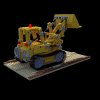

In [266]:
from PIL import Image
import torch
Image.fromarray((dataset.get_image_and_posture()[0] * 255).type(torch.uint8).numpy())

In [162]:
raygen = RayGenerator(height=H, width=W, focal=focal)
raysampler = StratifiedPointSampler(96)
origins, directions = raygen(posture=poses[0])
points, intervals = raysampler(origins, directions)
origins.shape, directions.shape, points.shape, intervals.shape

(torch.Size([100, 100, 3]),
 torch.Size([100, 100, 3]),
 torch.Size([100, 100, 96, 3]),
 torch.Size([96]))

In [103]:
directions.unsqueeze(-2).broadcast_to(points.shape)[0, 0].shape

torch.Size([96, 3])

In [66]:
import torch as tf
z_vals = tf.linspace(0, 1, 64)
intv = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.tensor([torch.finfo(torch.float).max])], -1)
# alpha = 1.-tf.exp(-sigma_a * dists)  
# weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
intv

tensor([1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02, 1.5873e-02,
        1.5873e-02, 1.5873e-02, 1.5873e-02, 3.4028e+38])